## Importing the Required Libraries

In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import pandas as pd
import json
import glob
# split data into train and test
from sklearn.model_selection import train_test_split
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models
# SVM classifier from scikit learn
from sklearn.svm import LinearSVC

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.preprocessing import StandardScaler, MinMaxScaler



%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Preparing the Data

In [2]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f) 
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)


In [3]:
stopwords = stopwords.words("english")

In [4]:
print (stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
filename  = '../../Data/Real and fake news/news'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.drop(orig_df.columns[[0,1]], axis = 1, inplace = True)
# orig_df.columns = ['Text', 'Label']
orig_df = orig_df.replace(to_replace=['FAKE', 'REAL'], value=[0, 1])

In [6]:
orig_df["text"] = orig_df["text"].astype(str)
orig_df["label"] = orig_df["label"].astype(str)
orig_df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1


In [7]:
df = orig_df

In [8]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [9]:
new_text, new_label = balanceClasses(df['text'], df['label'])

In [10]:
data = pd.DataFrame(new_text)
data.columns = ['text']
data['label'] = new_label
data = pd.concat([df, data])

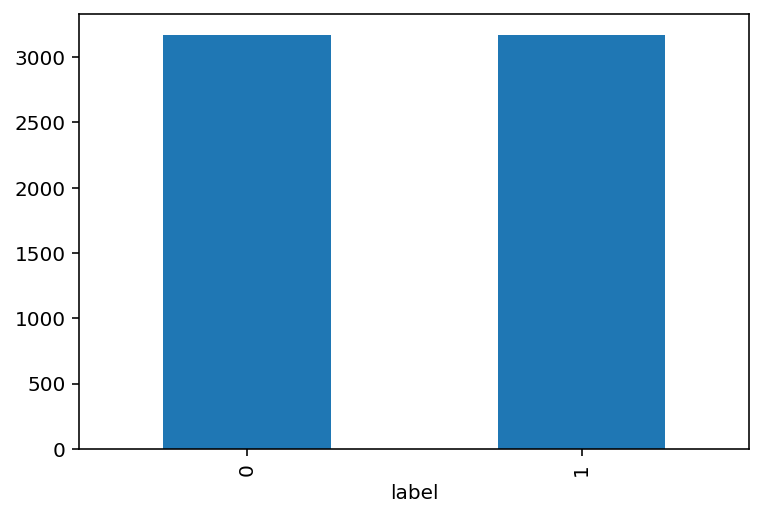

In [11]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(6,4))
data.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [12]:
data=data.sample(frac=1).reset_index(drop=True)

In [13]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceFourColon(x))

In [14]:
import re
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['text'] = data['text'].apply(lambda x: textPattern(x))

In [15]:
data.head()

,text,label
0,THE STING videos targeting Planned Parenthood ...,1
1,STRANGE THING moving up Alaska’s Chena River c...,0
2,By wmw_admin on October 30 2016 By Timothy Fit...,0
3,The decision of FBI Director Comey to go publ...,0
4,\nTwitter : batchelorshow Farming Invented Man...,0


In [16]:
print(len(data))

6341


In [17]:
# data = orig_df['Text']

data['text'].head()

0    THE STING videos targeting Planned Parenthood ...
1    STRANGE THING moving up Alaska’s Chena River c...
2    By wmw_admin on October 30 2016 By Timothy Fit...
3     The decision of FBI Director Comey to go publ...
4    \nTwitter : batchelorshow Farming Invented Man...
Name: text, dtype: object

In [18]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(data['text'])

In [19]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['sting', 'video', 'target', 'be', 'hard', 'watch', 'doctor', 'talk', 'clinically', 'say', 'callously', 'harvest', 'fetal', 'tissue', 'identify', 'isolate', 'tiny', 'organ', 'reference', 'be']


In [20]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['sting', 'video', 'target', 'be', 'hard', 'watch', 'doctor', 'talk', 'clinically', 'say', 'callously', 'harvest', 'fetal_tissue', 'identify', 'isolate', 'tiny', 'organ', 'reference', 'be', 'make']


In [21]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow


In [22]:
len(corpus)

6341

In [23]:
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
#                                            id2word=id2word,
#                                            num_topics=15,
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=50,
#                                            alpha="auto")

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=15,
                                           chunksize=100,
                                           workers=7, # Num. Processing Cores - 1
                                           passes=50,
                                           eval_every = 1,
                                           per_word_topics=True)

In [24]:
lda_model.save("test_model.model")

In [25]:
new_model = gensim.models.ldamodel.LdaModel.load("test_model.model")

In [26]:
train_vecs = []
for i in range(len(data)):
    top_topics = new_model.get_document_topics(corpus[i][:-1], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(15)]
    topic_vec.extend([len(data.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

In [27]:
train_vecs[2]

[0.700934,
 0.00043690435,
 0.13404658,
 0.0004369042,
 0.043428857,
 0.000436905,
 0.00043690627,
 0.00043690417,
 0.00043690478,
 0.0004369046,
 0.059575938,
 0.00043690376,
 0.0004369049,
 0.05764556,
 0.0004369045,
 3094]

In [28]:
# Using similar split 70/30
X = np.array(train_vecs)
y = np.array(data.label)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, data.index, test_size=0.30, random_state=100)

In [29]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

In [33]:
# model2 = LinearSVC(random_state=10, tol=1e-5, verbose=1, max_iter=1000000)
# model2.fit(X_train_scale, y_train)
# y_pred2 = model2.predict(X_test_scale)
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
clf = model.fit(X_train_scale, y_train)
y_pred2 = model.predict(X_test_scale)

In [34]:
results2 = confusion_matrix(y_test, y_pred2)
print ('Confusion Matrix :')
print(results2)
print ('Accuracy Score :',accuracy_score(y_test, y_pred2))
print ('Report : ')
print (classification_report(y_test, y_pred2))

Confusion Matrix :
[[472 450]
 [136 845]]
Accuracy Score : 0.6920651602732527
Report : 
              precision    recall  f1-score   support

           0       0.78      0.51      0.62       922
           1       0.65      0.86      0.74       981

    accuracy                           0.69      1903
   macro avg       0.71      0.69      0.68      1903
weighted avg       0.71      0.69      0.68      1903



In [35]:
# test_doc = corpus[-1]

# vector = new_model[test_doc]
# print (vector)
# For topic importance
# def Sort(sub_li):
#     sub_li.sort(key = lambda x: x[1])
#     sub_li.reverse()
#     return (sub_li)
# new_vector = Sort(vector)
# print (new_vector)

## Vizualizing the Data

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.195203 -0.197945       1        1  14.143823
1     -0.166861 -0.041855       2        1  13.708141
2     -0.341783 -0.111519       3        1  13.663795
0      0.029067 -0.265275       4        1   8.229617
13     0.095519 -0.058012       5        1   7.992695
9     -0.120466 -0.414433       6        1   7.517814
10     0.028548  0.280841       7        1   7.262178
4     -0.326580  0.091197       8        1   6.767765
6      0.056561  0.119439       9        1   6.400206
14    -0.276176  0.228432      10        1   5.248757
3     -0.088952  0.382968      11        1   3.048657
8      0.250692 -0.313649      12        1   2.752379
7      0.371850 -0.113482      13        1   1.597280
12     0.404765  0.106940      14        1   1.082137
11     0.279019  0.306353      15        1   0.584756, topic_info=         Term          Freq         Total Category  logprob  loglift
13         be  27095.000000  27095.000000  Default  30.0000  30.0000
157       say  20625.000000  20625.000000  Default  29.0000  29.0000
46         do   8952.000000   8952.000000  Default  28.0000  28.0000
78       have   8361.000000   8361.000000  Default  27.0000  27.0000
40     debate   2573.000000   2573.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2686  russian     57.903633   1498.991429  Topic15  -4.9935   1.8880
2741  network     46.934032    516.317367  Topic15  -5.2035   2.7438
985   comment     52.732599   1236.186115  Topic15  -5.0870   1.9872
1119     mind     45.845703    535.695686  Topic15  -5.2270   2.6834
1450   medium     41.624269   1703.640261  Topic15  -5.3236   1.4299

[1136 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
0          1  0.042564         abortion
0          3  0.129328         abortion
0         10  0.566425         abortion
0         13  0.258657         abortion
14683     13  0.963940  abortion_clinic
...      ...       ...              ...
5027       3  0.114619            youth
5027       4  0.013485            youth
5027       7  0.040454            youth
5027      12  0.721425            youth
6096       8  0.992689          zionist

[3228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 3, 1, 14, 10, 11, 5, 7, 15, 4, 9, 8, 13, 12])

/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
